# Overview
In this notebook we conduct additional 2 experiments: 
1. Investigating the impact of the 'skip probability' on the convergence of ***Scaffnew***
2. Investigating the impact of the 'number of local steps' on the convergence of ***LocalGD***


# Imports and Data splitting 
Please take a look at the 'exp_setup' and 'optimization_utilities' files for the definition of most functions 

Let's download an crucial package first

In [1]:
# ! pip install git+https://github.com/konstmish/opt_methods.git

In [2]:
import os
import urllib
import math
import random

import numpy as np
from sklearn import datasets
from typing import Sequence, Union, List, Tuple
from numpy.linalg import norm
from tqdm import tqdm

np.random.seed(69)
random.seed(69)

In [3]:
from exp_setup import split_into_batches, download_dataset
# download the data
DATA, LABELS = download_dataset()

# the number of devices used across the notebook
NUM_DEVICES = 16
DEVICES_DATA, DEVICES_LABELS = split_into_batches(DATA, y=LABELS, even_split=False, batch_size=int(math.ceil(DATA.shape[0] /NUM_DEVICES)))

In [4]:
# calculate the minimum number of samples in each device 
MIN_DEVICE_SIZE = min([d_data.shape[0] for d_data in DEVICES_DATA])
# set the batch size
BATCH_SIZE = MIN_DEVICE_SIZE // 4
print(BATCH_SIZE)

774


In [5]:
# ESTIMAT THE SMOOTHNESS CONSTANT
from exp_setup import L_estimation
PROBLEM_L = L_estimation(DEVICES_DATA, DEVICES_LABELS)
# SET THE REGULARIZATION PARAMETERS AS IN THE PAPER
PROBLEM_LAMBDA = PROBLEM_L * 10 ** -4
print(PROBLEM_L, PROBLEM_LAMBDA)
# set the LEARNING RATE: 
LEARNING_RATE = 1 / (PROBLEM_L)

0.6914564086632117 6.914564086632117e-05


In [6]:
from functools import partial
from exp_setup import lr_loss, stochastic_lr_gradient, stochastic_lr_loss, lr_gradient

DETERMINISTIC_FUNTION =partial(lr_loss, lam=PROBLEM_LAMBDA)
DETERMINISTIC_GRADIENT_FUNCTION = partial(lr_gradient, lam=PROBLEM_LAMBDA)
STOCHASTIC_FUNCTION = partial(stochastic_lr_loss, lam=PROBLEM_LAMBDA, batch_size=BATCH_SIZE)
STOCHASTIC_GRADIENT_FUNCTION = partial(stochastic_lr_gradient, lam=PROBLEM_LAMBDA, batch_size=BATCH_SIZE)

In [7]:
import optimization_utilities as opt
# create the set up: x_0 and seed
def set_up(seed: int = 69) -> np.ndarray:
        # changing the seed mainly changes the starting point
    random.seed(seed)
    np.random.seed(seed)
    w_0 = np.random.randn(DATA.shape[1], 1)
    return w_0

# find the minimum value of the function
TRUE_MIN = opt.find_x_true(DATA, LABELS, lam=PROBLEM_LAMBDA) 
print(TRUE_MIN)

0.13741784372775287


# Local GD and number of local steps

In [8]:
import matplotlib.pyplot as plt
def plot_iterations(criterions: List[float],
                    start_index: int = 0, 
                    end_index: int = -1,
                    plot_label: str = None,
                    x_label: str = None,
                    y_label: str = None,
                    show:bool = True,
                    ):
    
    end_index = (end_index + len(criterions)) % len(criterions)

    if plot_label is None:
        plt.plot(list(range(start_index, end_index)), criterions[start_index:end_index])
    else:
        plt.plot(list(range(start_index, end_index)), criterions[start_index:end_index], label=str(plot_label))
    

    plt.xlabel('iteration' if x_label is None else x_label)
    plt.ylabel('criterion (log_{10} scale)' if x_label is None else y_label)
    
    if show:
        plt.legend()
        plt.show()

In [9]:
CRITERION = lambda x: np.mean([lr_loss(d_data, d_label, x, PROBLEM_LAMBDA) for d_data, d_label in zip(DEVICES_DATA, DEVICES_LABELS)]) - TRUE_MIN
X0 = set_up()
INITIAL_VALUE = CRITERION(X0)

  6%|▌         | 30/500 [00:10<02:38,  2.97it/s]


KeyboardInterrupt: 

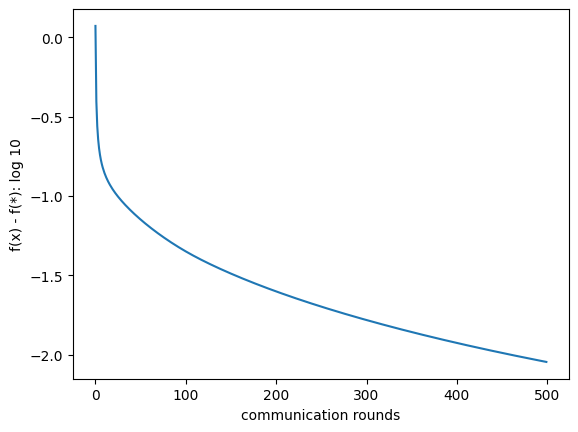

In [10]:
import optimization_utilities as opt
import importlib
importlib.reload(opt)

communication_rounds = 500

num_local_steps = [10, 100, 200, 500]

for nls in num_local_steps:
    k = communication_rounds * nls
    local_gd_xpoints, local_gd_criterions = opt.localGD(
                                                    num_local_steps=nls,
                                                    device_data=DEVICES_DATA, 
                                                    device_labels=DEVICES_LABELS,
                                                    function=DETERMINISTIC_FUNTION,
                                                    gradient_function=DETERMINISTIC_GRADIENT_FUNCTION,            
                                                    x_0=X0.copy(),
                                                    mode=CRITERION, 
                                                    gamma_k=lambda _ :1 / LEARNING_RATE, 
                                                    K=k
                                                    )
    local_gd_criterions = [INITIAL_VALUE] + local_gd_criterions
    # convert the criterion value1s to log 'scale'
    local_gd_log_criterions = [np.log10(c) for c in local_gd_criterions]
    plot_iterations(criterions=local_gd_log_criterions, 
                    x_label='communication rounds', 
                    y_label='f(x) - f(*): log 10',
                    plot_label=f'steps: {nls}', 
                    show=False)

plt.legend()
plt.title(f"Local Gradient Descent with different local steps")
plt.show()

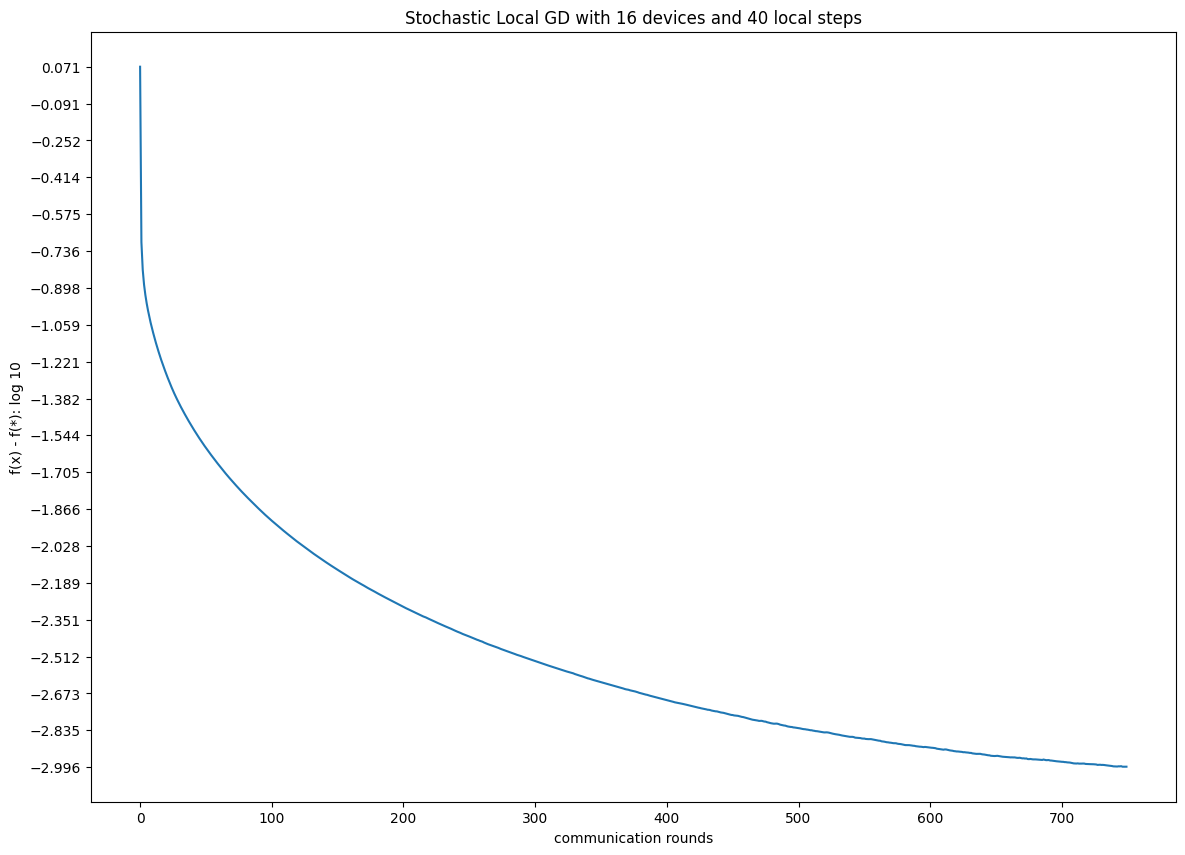

In [ ]:
plt.figure(figsize=(14, 10))
plot_iterations(criterions=local_gd_log_criterions, 
                x_label='communication rounds', 
                y_label='f(x) - f(*): log 10', 
                show=False)
plt.yticks(np.linspace(np.min(local_gd_log_criterions), np.max(local_gd_log_criterions), num=20))
plt.title(f"Stochastic Local GD with {NUM_DEVICES} devices and {NUM_LOCAL_STEPS} local steps")
plt.show()

## Stochastic ProxSkip

In [11]:
# the optimial prox skip probability
PROX_SKIP_PROBABILITY = np.sqrt(PROBLEM_LAMBDA / LEARNING_RATE)
# add some extra 
PROX_SKIP_K =  K ** 2
print(PROX_SKIP_PROBABILITY)

NameError: name 'K' is not defined

In [ ]:
import optimization_utilities as opt
import importlib
importlib.reload(opt)
prox_xpoints, prox_criterions = opt.proxSkipFL(
            devices_data=DEVICES_DATA, 
            devices_labels=DEVICES_LABELS,
            function=DETERMINISTIC_FUNTION,
            gradient_function=STOCHASTIC_GRADIENT_FUNCTION,
            skip_probability=PROX_SKIP_PROBABILITY, 
            communication_rounds=COMMUNICATION_ROUNDS,
            x_0=set_up(), 
            max_iterations=PROX_SKIP_K, 
            gamma_k=lambda _ : 1 / LEARNING_RATE,
            mode=CRITERION,
            report_by_prox=50,
            )

# add the initial value 
prox_criterions = [INITIAL_VALUE] + prox_criterions
prox_log_criterions = [np.log10(max(c, 10 ** -8)) for c in prox_criterions]

  0%|          | 385/900000000 [00:01<876:47:09, 285.13it/s]

Communication conducted: 1 times


  0%|          | 8586/900000000 [00:29<841:33:36, 297.06it/s]

Communication conducted: 51 times


  0%|          | 17557/900000000 [00:59<858:04:06, 291.35it/s]

Communication conducted: 101 times


  0%|          | 26359/900000000 [01:29<841:42:28, 297.01it/s]

Communication conducted: 151 times


  0%|          | 32726/900000000 [01:51<859:42:17, 290.79it/s]

Communication conducted: 201 times


  0%|          | 38590/900000000 [02:11<884:18:16, 282.70it/s]

Communication conducted: 251 times


  0%|          | 46212/900000000 [02:37<846:32:43, 295.30it/s]

Communication conducted: 301 times


  0%|          | 52704/900000000 [02:59<858:42:15, 291.12it/s]

Communication conducted: 351 times


  0%|          | 60916/900000000 [03:27<854:05:16, 292.69it/s]

Communication conducted: 401 times


  0%|          | 69394/900000000 [03:56<857:29:30, 291.53it/s]

Communication conducted: 451 times


  0%|          | 75927/900000000 [04:18<851:40:05, 293.52it/s]

Communication conducted: 501 times


  0%|          | 82579/900000000 [04:41<844:54:43, 295.86it/s]

Communication conducted: 551 times


  0%|          | 89035/900000000 [05:03<842:29:08, 296.71it/s]

Communication conducted: 601 times


  0%|          | 96439/900000000 [05:28<849:24:28, 294.29it/s]

Communication conducted: 651 times


  0%|          | 103233/900000000 [05:52<840:17:10, 297.48it/s]

Communication conducted: 701 times


  0%|          | 111564/900000000 [06:20<851:40:01, 293.51it/s]


In [ ]:
local_gd_log_criterions = [np.log10(INITIAL_VALUE)] + local_gd_log_criterions
prox_log_criterions = [np.log10(INITIAL_VALUE)] + prox_log_criterions

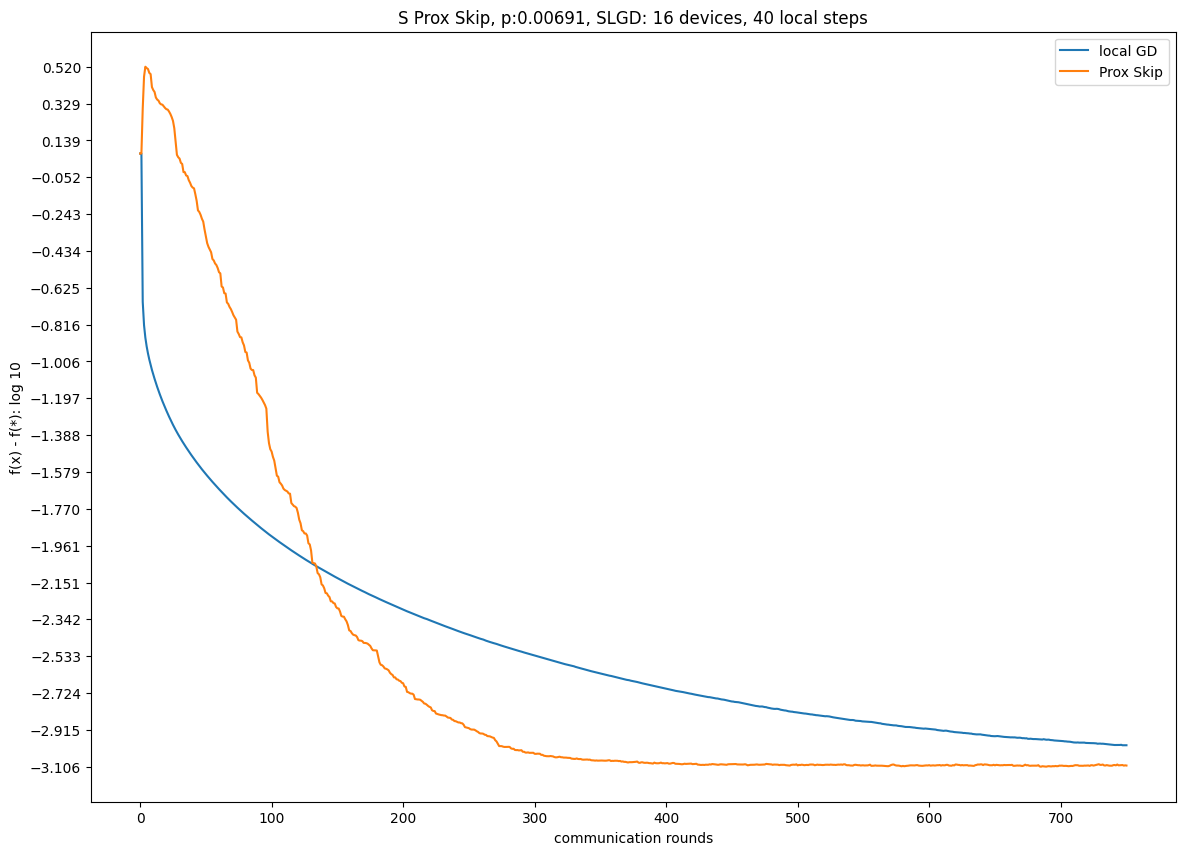

In [ ]:
plt.figure(figsize=(14, 10))

plot_iterations(criterions=local_gd_log_criterions, 
                x_label='communication rounds', 
                y_label='f(x) - f(*): log 10', 
                plot_label='local GD',
                show=False)

plot_iterations(criterions=prox_log_criterions, 
                x_label='communication rounds', 
                y_label='f(x) - f(*): log 10', 
                plot_label='Prox Skip',
                show=False)

plt.yticks(np.linspace(
                        start=min(np.min(local_gd_log_criterions), np.min(prox_log_criterions)), 
                        stop=max(np.max(local_gd_log_criterions), np.max(prox_log_criterions)),num=20
                                 ))
plt.legend()
plt.title(f'S Prox Skip, p:{round(PROX_SKIP_PROBABILITY, 5)}, SLGD: {NUM_DEVICES} devices, {NUM_LOCAL_STEPS} local steps')
plt.show()

# Scaffnew with different probabilities

In [17]:
COMMUNICATION_ROUNDS = 500

In [18]:
X0 = set_up()
INITIAL_VALUE = CRITERION(X0)
INITIAL_VALUE

1.176653755118379

In [19]:
PROX_SKIP_PROBABILITY = np.sqrt(PROBLEM_LAMBDA / (PROBLEM_L))
PROX_SKIP_PROBABILITY

0.01

 26%|██▌       | 257724/1000000 [15:22<44:15, 279.50it/s] 


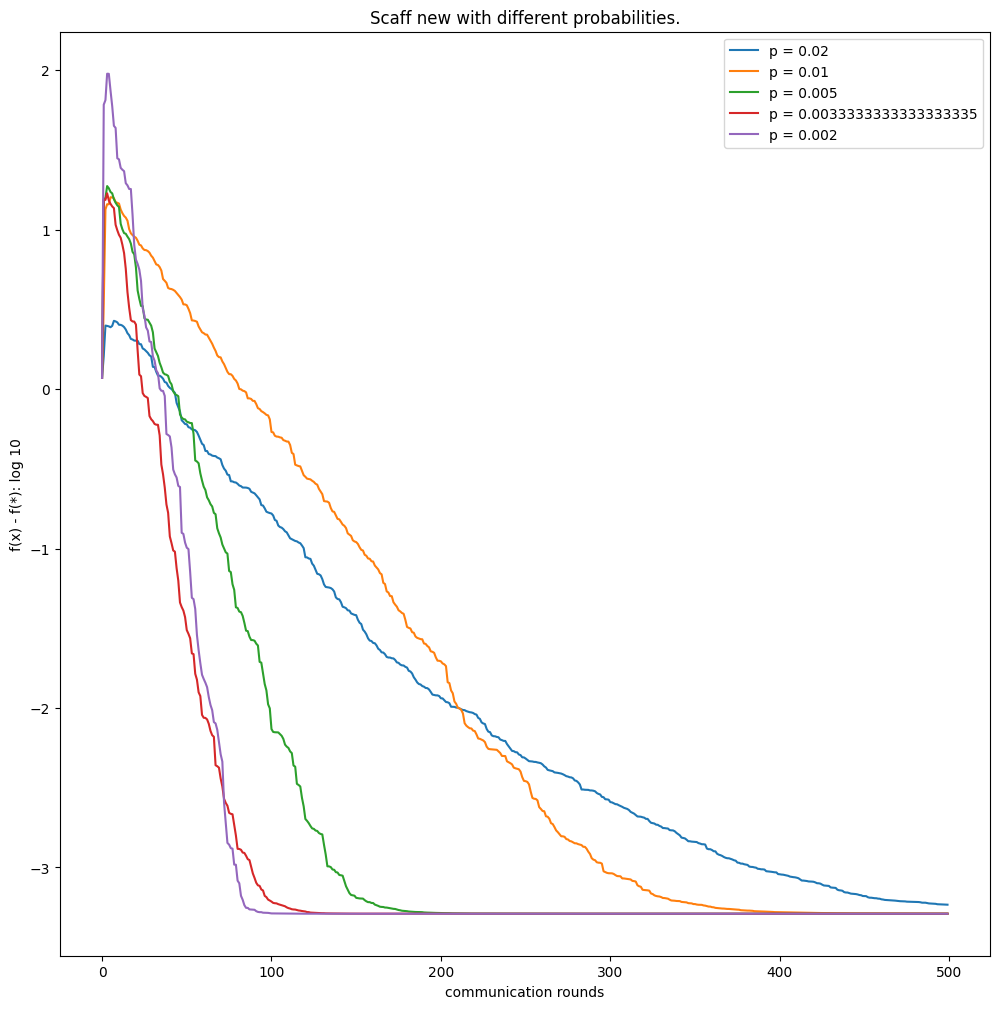

In [20]:
plt.figure(figsize=(12, 12))
for p in [1 / 50, 1 / 100, 1 / 200, 1 / 300, 1 / 500]: 
    prox_xpoints, prox_criterions = opt.proxSkipFL(
                devices_data=DEVICES_DATA, 
                devices_labels=DEVICES_LABELS,
                function=DETERMINISTIC_FUNTION,
                gradient_function=DETERMINISTIC_GRADIENT_FUNCTION,
                skip_probability=p, 
                communication_rounds=COMMUNICATION_ROUNDS,
                x_0=set_up(), 
                max_iterations=10 ** 6, 
                gamma_k=lambda _ : 1 / PROBLEM_L,
                mode=CRITERION,
                report_by_prox=5
                )

    prox_criterions = [INITIAL_VALUE] + prox_criterions
    prox_log_criterions = [np.log10(c) for c in prox_criterions]
    plot_iterations(criterions=prox_log_criterions, 
                    x_label='communication rounds', 
                    y_label='f(x) - f(*): log 10', 
                    plot_label=f'p = {round(p, 5)}',
                    show=False)

plt.legend()
plt.title(f'Scaff new with different probabilities.')
plt.show()


In [21]:
plt.show()